In [2]:
import numpy as np
import os
import wfdb
from collections import Counter
import pickle
import random
import sys
from tqdm import tqdm

label_group_map = {'N':'N', 'L':'N', 'R':'N', 'V':'V', '/':'Q', 'A':'S', 'F':'F', 'f':'Q', 'j':'S', 'a':'S', 'E':'V', 'J':'S', 'e':'S', 'Q':'Q', 'S':'S'}

def resample_unequal(ts, fs_in, fs_out):
    """
    interploration
    """
    fs_in, fs_out = int(fs_in), int(fs_out)
    if fs_out == fs_in:
        return ts
    else:
        x_old = np.linspace(0, 1, num=fs_in, endpoint=True)
        x_new = np.linspace(0, 1, num=fs_out, endpoint=True)
        y_old = ts
        f = interp1d(x_old, y_old, kind='linear')
        y_new = f(x_new)
        return y_new

if __name__ == "__main__":

    path = 'mit-bih-arrhythmia-database-1.0.0'
    save_path = 'data/'
    # valid_lead = ['MLII', 'II', 'I', 'MLI', 'V5'] 
    valid_lead = ['MLII'] 
    fs_out = 360
    test_ratio = 0.2

    train_ind = []
    test_ind = []
    all_pid = []
    all_data = []
    all_label = []
    all_group = []

    with open(os.path.join(path, 'RECORDS'), 'r') as fin:
        all_record_name = fin.read().strip().split('\n')
    test_pid = random.choices(all_record_name, k=int(len(all_record_name)*test_ratio))
    train_pid = list(set(all_record_name) - set(test_pid))

    for record_name in all_record_name:
        try:
            tmp_ann_res = wfdb.rdann(path + '/' + record_name, 'atr').__dict__
            tmp_data_res = wfdb.rdsamp(path + '/' + record_name)
        except:
            print('read data failed')
            continue
        fs = tmp_data_res[1]['fs']
        ## total 1 second for each
        left_offset = int(1.0*fs / 2)
        right_offset = int(fs) - int(1.0*fs / 2)

        lead_in_data = tmp_data_res[1]['sig_name']
        my_lead_all = []
        for tmp_lead in valid_lead:
            if tmp_lead in lead_in_data:
                my_lead_all.append(tmp_lead)
        if len(my_lead_all) != 0:
            for my_lead in my_lead_all:
                channel = lead_in_data.index(my_lead)
                tmp_data = tmp_data_res[0][:, channel]

                idx_list = list(tmp_ann_res['sample'])
                label_list = tmp_ann_res['symbol']
                for i in range(len(label_list)):
                    s = label_list[i]
                    if s in label_group_map.keys():
                        idx_start = idx_list[i]-left_offset
                        idx_end = idx_list[i]+right_offset
                        if idx_start < 0 or idx_end > len(tmp_data):
                            continue
                        else:
                            all_pid.append(record_name)
                            all_data.append(resample_unequal(tmp_data[idx_start:idx_end], fs, fs_out))
                            all_label.append(s)
                            all_group.append(label_group_map[s])
                            if record_name in train_pid:
                                train_ind.append(True)
                                test_ind.append(False)
                            else:
                                train_ind.append(False)
                                test_ind.append(True)
                    else:
                        continue
                print('record_name:{}, lead:{}, fs:{}, cumcount: {}'.format(record_name, my_lead, fs, len(all_pid)))
        else:
            print('lead in data: [{0}]. no valid lead in {1}'.format(lead_in_data, record_name))
            continue

    all_pid = np.array(all_pid)
    all_data = np.array(all_data)
    all_label = np.array(all_label)
    all_group = np.array(all_group)
    train_ind = np.array(train_ind)
    test_ind = np.array(test_ind)
    print(all_data.shape)
    print(all_label.shape, np.sum(train_ind), np.sum(test_ind))
    print(Counter(all_label))
    print(Counter(all_group))
    print(Counter(all_group[train_ind]), Counter(all_group[test_ind]))
    np.save(os.path.join(save_path, 'mitdb_data.npy'), all_data)
    np.save(os.path.join(save_path, 'mitdb_label.npy'), all_label)
    np.save(os.path.join(save_path, 'mitdb_group.npy'), all_group)
    np.save(os.path.join(save_path, 'mitdb_pid.npy'), all_pid)
    np.save(os.path.join(save_path, 'mitdb_train_ind.npy'), train_ind)
    np.save(os.path.join(save_path, 'mitdb_test_ind.npy'), test_ind)

record_name:100, lead:MLII, fs:360, cumcount: 2271
record_name:101, lead:MLII, fs:360, cumcount: 4135
lead in data: [['V5', 'V2']]. no valid lead in 102
record_name:103, lead:MLII, fs:360, cumcount: 6218
lead in data: [['V5', 'V2']]. no valid lead in 104
record_name:105, lead:MLII, fs:360, cumcount: 8790
record_name:106, lead:MLII, fs:360, cumcount: 10817
record_name:107, lead:MLII, fs:360, cumcount: 12953
record_name:108, lead:MLII, fs:360, cumcount: 14715
record_name:109, lead:MLII, fs:360, cumcount: 17245
record_name:111, lead:MLII, fs:360, cumcount: 19369
record_name:112, lead:MLII, fs:360, cumcount: 21906
record_name:113, lead:MLII, fs:360, cumcount: 23699
record_name:114, lead:MLII, fs:360, cumcount: 25578
record_name:115, lead:MLII, fs:360, cumcount: 27529
record_name:116, lead:MLII, fs:360, cumcount: 29940
record_name:117, lead:MLII, fs:360, cumcount: 31474
record_name:118, lead:MLII, fs:360, cumcount: 33751
record_name:119, lead:MLII, fs:360, cumcount: 35738
record_name:121, l

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 360, 1)]     0           []                               
                                                                                                  
 conv1d_42 (Conv1D)             (None, 360, 128)     512         ['input_8[0][0]']                
                                                                                                  
 conv1d_43 (Conv1D)             (None, 360, 128)     49280       ['conv1d_42[0][0]']              
                                                                                                  
 max_pooling1d_21 (MaxPooling1D  (None, 180, 128)    0           ['conv1d_43[0][0]']              
 )                                                                                          

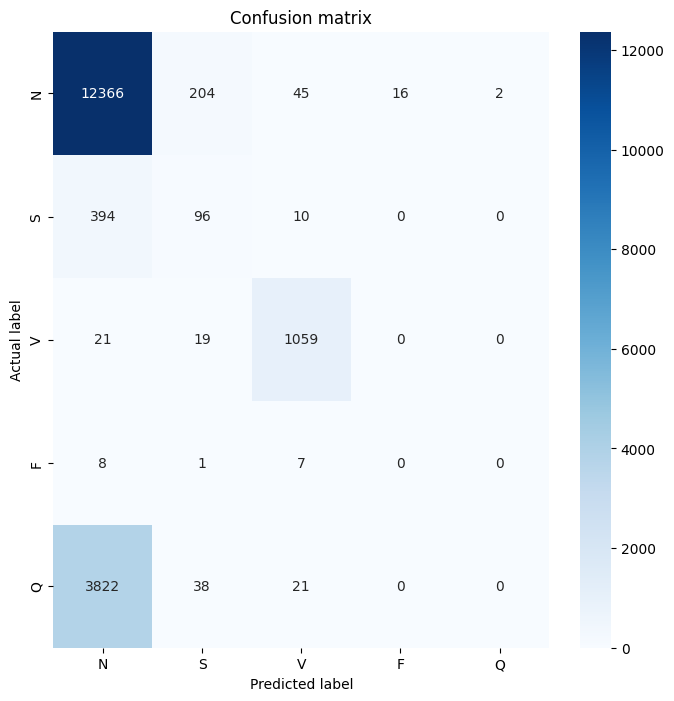

In [26]:
import numpy as np
import os
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras import layers, models, callbacks, utils
import keras_nlp as nlp

def label2index(i):
    m = {'N':0, 'S':1, 'V':2, 'F':3, 'Q':4}
    return m[i]

def vgg_block(input, cnn_units):
    output = input
    output = layers.Conv1D(cnn_units, 3, padding='same', activation='relu')(output)
    output = layers.Conv1D(cnn_units, 3, padding='same', activation='relu')(output)
    output = layers.MaxPooling1D(2, padding='same')(output)
    return output

def create_network(segment_length, number_of_leads=1, cnn_units=128, vgg_blocks=1, rnn_units=64,
                   transformer_encoders=4, att_dim=64, att_heads=8, fnn_units=64, num_classes=5):
    input = layers.Input(shape=(segment_length, number_of_leads))
    output = input

    for _ in range(vgg_blocks):
        output = vgg_block(output, cnn_units)

    output = layers.Bidirectional(layers.GRU(rnn_units, return_sequences=True), merge_mode='sum')(output)

    if transformer_encoders > 0:
        output = output + nlp.layers.SinePositionEncoding(max_wavelength=10000)(output)

        for _ in range(transformer_encoders):
            output = nlp.layers.TransformerEncoder(att_dim, att_heads)(output)

        output = layers.GlobalAveragePooling1D()(output)

    output = layers.Dropout(0.2)(output)
    output = layers.Dense(fnn_units, activation='relu')(output)
    output = layers.Dense(fnn_units, activation='relu')(output)
    output = layers.Dense(num_classes, activation='softmax')(output)
    model = models.Model(input, output)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

def load_and_preprocess_data(path, num_classes):
    data = np.load(os.path.join(path, 'mitdb_data.npy'))
    label_str = np.load(os.path.join(path, 'mitdb_group.npy'))
    label = np.array([label2index(i) for i in label_str])

    train_ind = np.load(os.path.join(path, 'mitdb_train_ind.npy'))
    test_ind = np.load(os.path.join(path, 'mitdb_test_ind.npy'))
    data = preprocessing.scale(data, axis=1)
    X_train = data[train_ind]
    X_test = data[test_ind]
    Y_train = utils.to_categorical(label[train_ind], num_classes=num_classes)
    Y_test = utils.to_categorical(label[test_ind], num_classes=num_classes)

    ros = RandomOverSampler(random_state=0)
    X_train, Y_train = ros.fit_resample(X_train, Y_train)

    return X_train, X_test, Y_train, Y_test

def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    """
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion matrix')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    return figure

if __name__ == "__main__":
    path = 'data/'
    segment_length = 360
    num_classes = 5
    class_names = ['N', 'S', 'V', 'F', 'Q']  # Update based on your classes

    X_train, X_test, Y_train, Y_test = load_and_preprocess_data(path, num_classes)
    
    model = create_network(segment_length=segment_length, number_of_leads=1, num_classes=num_classes)
    model.summary()

    # Define callbacks
    stopping = callbacks.EarlyStopping(patience=5)
    reduce_lr = callbacks.ReduceLROnPlateau(factor=0.1, patience=3, min_lr=0.001*0.001)

    # Train the model
    model.fit(X_train, Y_train, epochs=20, batch_size=256, validation_data=(X_test, Y_test))

    # Evaluate the model
    test_loss, test_acc = model.evaluate(X_test, Y_test, verbose=2)
    print(f"Test accuracy: {test_acc * 100:.2f}%")

    # Predictions for confusion matrix and classification report
    Y_pred = model.predict(X_test)
    Y_pred_classes = np.argmax(Y_pred, axis=1)
    Y_true_classes = np.argmax(Y_test, axis=1)

    # Classification report
    print(classification_report(Y_true_classes, Y_pred_classes, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(Y_true_classes, Y_pred_classes)
    fig = plot_confusion_matrix(cm, class_names)
    plt.show()